<a href="https://colab.research.google.com/github/kdorais/ML-projects/blob/main/METCS767.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dog Breed classification
**Author:** kdorais <br>
**Date created:** 2022/05/22 <br>
**Last modified:** 2020/05/28 <br>
**Description:** Training an Dog breed classifier Dog_images dataset.<br>

## Introduction

This project shows how to do dog breed classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
application model. We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import timeit
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential, Model
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten
from keras.regularizers import l2
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D
from keras.layers import Dropout, Flatten, Dense, AvgPool2D, BatchNormalization, Activation
from PIL import ImageFile

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

We have a `dog_Images` folder which contain four subfolders, `bernese_mountain_dog`,  `border_collie_dog`, `chihuahua_dog` and	`pug_dog`. Each
 subfolder contains image files for each category.

In [ ]:
!ls "/content/drive/MyDrive/dog_images/"

bernese_mountain_dog  border_collie_dog  chihuahua_dog	pug_dog


## Generate the data:

First, let's fetch the dogs dataset using 
`tf.keras.preprocessing.image_dataset_from_directory` to generate similar labeled dataset objects from a set of images on disk filed into class-specific folders.

In [ ]:
image_size = (224,224)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dog_images",
    validation_split=0.2,
    subset="training",
    label_mode = "int",
    color_mode = 'rgb',
    seed=1234,
    image_size=image_size,
    batch_size=batch_size
  
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dog_images",
    validation_split=0.2,
    subset="validation",
    label_mode = "int",
    color_mode = 'rgb',
    seed=1234,
    image_size=image_size,
    batch_size=batch_size
    
)


Found 4335 files belonging to 4 classes.
Using 3468 files for training.
Found 4335 files belonging to 4 classes.
Using 867 files for validation.


In [ ]:
# loading data
img_height=224
img_width=224
batch_size=32
train_datagen = ImageDataGenerator(rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.5,
    brightness_range=[0.4,1.5],
    horizontal_flip=True,
    rotation_range=30,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/dog_images",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='rgb',
    seed = 9394,
    subset='training') # set as training data

test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

validation_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/dog_images", # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='rgb',
    seed = 9394,
    subset='validation') # set as validation data

Found 3470 images belonging to 4 classes.
Found 865 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


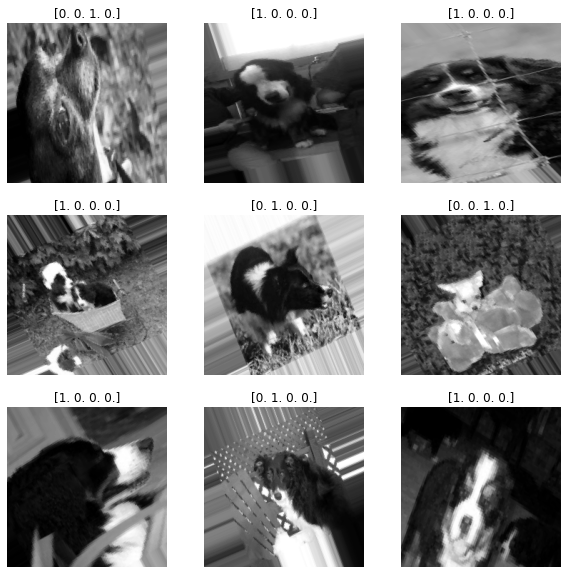

In [ ]:
# plotting images

plt.figure(figsize=(10, 10))
x, y = train_generator.next()
for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    image = x[i]
    label = (y[i])
    plt.imshow(image[:,:,0], cmap='gray')
    plt.title(label)
    plt.axis("off")

## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 to label 4 of 4 "dog breed class"
 .

In [ ]:
def lab(y):
  if y == 0.0:
     lab = 'Bernese_mountain_dog'
  elif y == 1.0: 
       lab = 'Border_collie_dog'
  elif y == 2.0: 
       lab = 'chihuahua_dog'
  elif y == 3.0: 
       lab = 'pug_dog'
  return lab


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
x, y = train_generator.next()
for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    image = x[i]
    label = lab(y[i])
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
  

'\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(10, 10))\nx, y = train_generator.next()\nfor i in range(0,9):\n    ax = plt.subplot(3, 3, i + 1)\n    image = x[i]\n    label = lab(y[i])\n    plt.imshow(image)\n    plt.title(label)\n    plt.axis("off")\n'

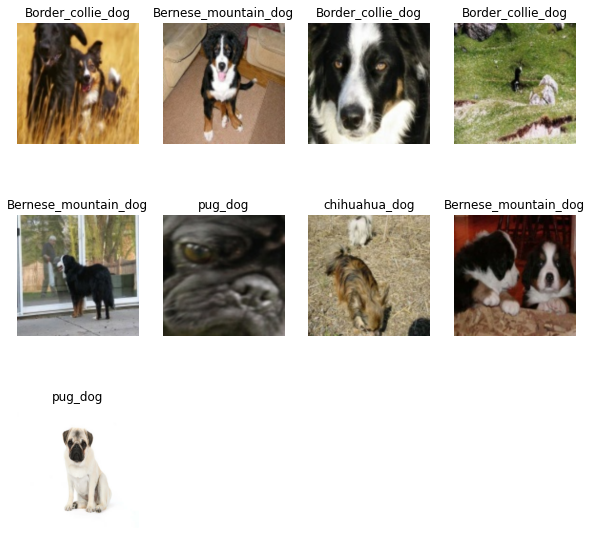

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 4, i + 1)
        image = images[i]
        #image = image[:,:,0]
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(lab(int(labels[i])))
        plt.axis("off")
       


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.

Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomCrop(128, 128)
        
        
    ]
)

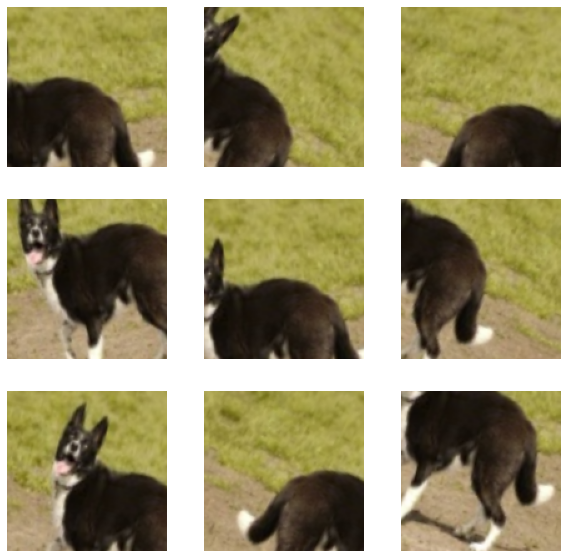

In [ ]:
import matplotlib.pyplot as plt
"""
plt.figure(figsize=(10, 10))
x, y = train_generator.next()
for i in range(0,9):
    augmented_images = data_augmentation(x)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0])
    plt.axis("off")
"""
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:


In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.

## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [ ]:

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Create a CNN to Classify Dog Breeds from Scratch

### Build CNN model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture.

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


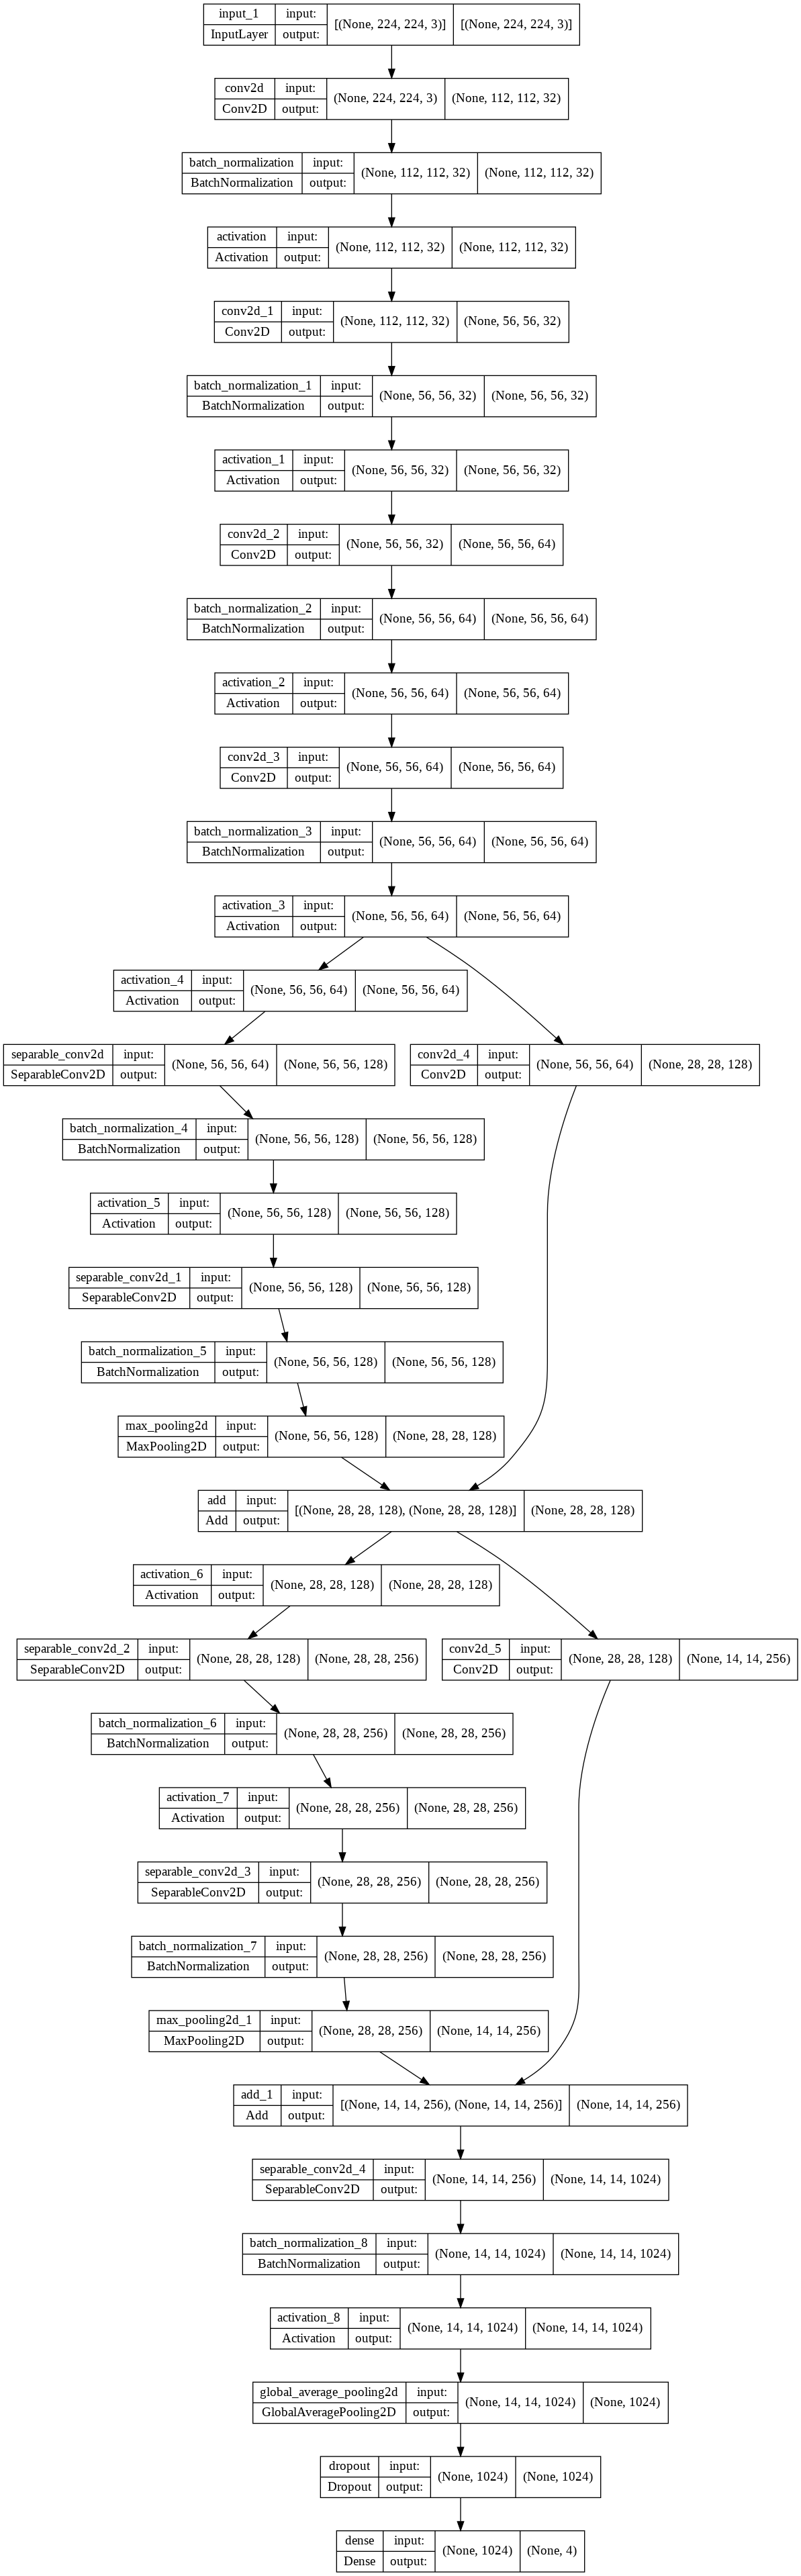

In [ ]:
from keras.engine import sequential
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)

    # Entry block
    #x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    
    for size in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)       
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

image_size = (224,224)
model_cnn = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model_cnn, show_shapes=True)


## Compile model CNN
Both, categorical cross entropy and sparse categorical cross entropy have the same loss function, the only difference is the format in which you mention 𝑌𝑖 (i,e true labels) are one-hot encoded, use categorical_crossentropy. Examples (for a 4-class classification): [1,0,0,0] , [0,1,0,0], [0,0,1,0]

But if your 𝑌𝑖's are integers, use sparse_categorical_crossentropy. Examples for above 4-class classification problem: [0], [1], [2], [3]

In [ ]:
model_cnn.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

## Train the CNN model

In [ ]:
epoch = 25
batch_size = 32
stop_patience = 5

In [ ]:
#Fit the model
hist_cnn = model_cnn.fit(x = train_generator, validation_data = validation_generator, epochs=50, batch_size=batch_size) 
                         

Epoch 1/50
109/109 [==============================] - 906s 8s/step - loss: 1.5070 - accuracy: 0.3049 - val_loss: 1.3879 - val_accuracy: 0.2393
Epoch 2/50
109/109 [==============================] - 57s 525ms/step - loss: 1.3253 - accuracy: 0.3804 - val_loss: 1.3882 - val_accuracy: 0.2682
Epoch 3/50
109/109 [==============================] - 58s 533ms/step - loss: 1.3022 - accuracy: 0.3873 - val_loss: 1.3926 - val_accuracy: 0.2393
Epoch 4/50
109/109 [==============================] - 57s 526ms/step - loss: 1.2580 - accuracy: 0.4156 - val_loss: 1.4960 - val_accuracy: 0.2705
Epoch 5/50
109/109 [==============================] - 57s 520ms/step - loss: 1.2071 - accuracy: 0.4337 - val_loss: 1.2156 - val_accuracy: 0.4393
Epoch 6/50
109/109 [==============================] - 57s 520ms/step - loss: 1.1651 - accuracy: 0.4841 - val_loss: 1.2714 - val_accuracy: 0.4370
Epoch 7/50
109/109 [==============================] - 58s 530ms/step - loss: 1.1231 - accuracy: 0.5228 - val_loss: 1.0196 - val_accu

### Load Model Keras

In [ ]:
model_cnn.save('/content/drive/MyDrive/best_model1_cnn.h5')

In [ ]:
from keras.models import load_model
model_cnn = load_model('/content/drive/MyDrive/best_model1_cnn.h5')

In [ ]:
def path_to_tensor(img_path):
  #Load RGB image to PIL.Image.Image type
  img = image.load_img(img_path, target_size = (224,224))
  #convert PIL.Image.Image type to 3D tensor with shape (224,224,3)
  x = image.img_to_array(img)
  #convert 3D tensor to 4D tensor with shape (1,224,224,3)
  return np.expand_dims(x,axis=0)


In [ ]:
def cnn_predict_label(img_path):
  # returns prediction vector for image located at img_path
  img = preprocess_input(path_to_tensor(img_path))
  return np.argmax(model_cnn.predict(img))

This dog's breed is chihuahua_dog


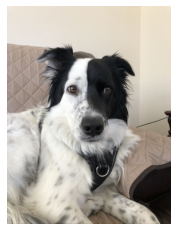

In [ ]:
from PIL import Image
file = '/content/drive/MyDrive/dogs/IMG_4143.jpeg'
label = lab(cnn_predict_label(file))
img = preprocess_input(path_to_tensor(file))
print("This dog's breed is {}".format(label))

pic = Image.open(file)
plt.imshow(pic)
plt.axis("off")
plt.show()

### Visualize CNN model accuracy and loss

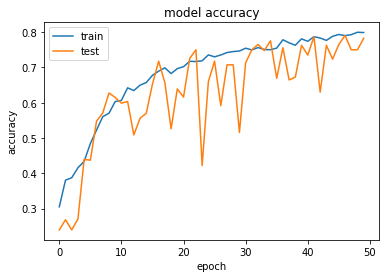

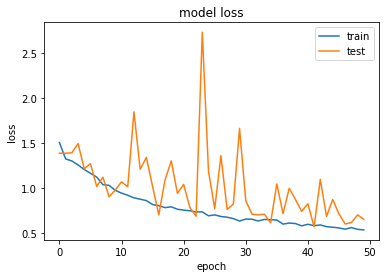

In [ ]:
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

plt.figure()
plt.gcf().clear()
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()


## Build an Image Classifier with SVM
For this model we'll use ImageDataGenerator for data augmentation as shown below:

In [ ]:
# Load the data
img_height=224
img_width=224
batch_size=32

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 45,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_set= train_datagen.flow_from_directory(
    "/content/drive/MyDrive/dog_images",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

test_set = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/dog_images", # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 3470 images belonging to 4 classes.
Found 865 images belonging to 4 classes.


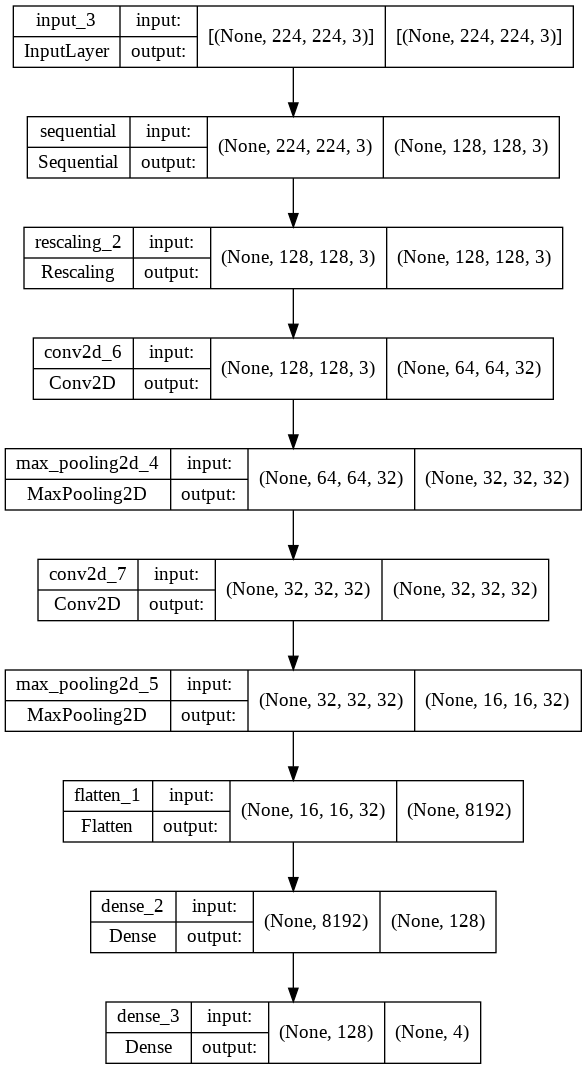

In [ ]:
# Model creation
def svm_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)

    # Entry block
    #x = layers.Rescaling(1.0 / 255)(x)
    model_svm = Sequential()
    #x = layers.
    model_svm.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2))
    #x = layers.
    model_svm.add(MaxPool2D(pool_size=(2,2),strides = 2))

    #x = layers.
    model_svm.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
    #x = layers.
    model_svm.add(MaxPool2D(pool_size=(2,2),strides = 2))

    #x = layers.
    model_svm.add(Flatten())
    #x = layers.
    model_svm.add(Dense(128,activation="relu"))

    #Output layer
    output = layers.Dense(4,kernel_regularizer=l2(0.01),activation = "softmax")(x)
    return keras.Model(inputs, output)

image_size = (224,224)
model_svm = svm_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model_svm, show_shapes=True)

## Compile
If our problem was a Multiclass classification problem then we’ve to use squared_hinge as loss function & softmax as activation function during compiling for SVM

In [ ]:
model_svm.compile(optimizer=keras.optimizers.Adam(1e-3), loss='squared_hinge', metrics = ['accuracy'])

## Train the SVM model

In [ ]:
hist_svm = model_svm.fit(x = train_ds, validation_data = val_ds, epochs=50, batch_size=32)


Epoch 1/50
109/109 [==============================] - 11s 85ms/step - loss: 0.5142 - accuracy: 0.2442 - val_loss: 0.4765 - val_accuracy: 0.2561
Epoch 2/50
109/109 [==============================] - 10s 86ms/step - loss: 0.4784 - accuracy: 0.2460 - val_loss: 0.4614 - val_accuracy: 0.2364
Epoch 3/50
109/109 [==============================] - 10s 86ms/step - loss: 0.4706 - accuracy: 0.2517 - val_loss: 0.4583 - val_accuracy: 0.2284
Epoch 4/50
109/109 [==============================] - 10s 87ms/step - loss: 0.4691 - accuracy: 0.2552 - val_loss: 0.4577 - val_accuracy: 0.2664
Epoch 5/50
109/109 [==============================] - 11s 99ms/step - loss: 0.4688 - accuracy: 0.2601 - val_loss: 0.4576 - val_accuracy: 0.2826
Epoch 6/50
109/109 [==============================] - 11s 98ms/step - loss: 0.4687 - accuracy: 0.2673 - val_loss: 0.4582 - val_accuracy: 0.2907
Epoch 7/50
109/109 [==============================] - 10s 88ms/step - loss: 0.4687 - accuracy: 0.2555 - val_loss: 0.4575 - val_accuracy:

KeyboardInterrupt: ignored

## Visualize the SVM model accuracy and loss

In [ ]:
plt.plot(hist_svm.history['accuracy'])
plt.plot(hist_svm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

plt.figure()
plt.gcf().clear()
plt.plot(hist_svm.history['loss'])
plt.plot(hist_svm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()


NameError: ignored

## Create a CNN to Classify Dog Breeds (using Transfer Learning)

In [ ]:
# loading data
img_height=224
img_width=224
batch_size=32
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=0.1,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/dog_images",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    seed = 9394,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/dog_images", # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    seed = 9394,
    subset='validation') # set as validation data

Found 3470 images belonging to 4 classes.
Found 865 images belonging to 4 classes.


In [ ]:
inputs = keras.Input(shape=(224,224,3))

In [ ]:
inputs

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_3')>

In [ ]:
from keras.layers.preprocessing.image_preprocessing import Rescaling
# Build the model
def model_vgg19(input_shape, num_classes):
  #inputs = keras.Input(shape=input_shape)
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape, filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=num_classes, activation="softmax"))
  return model

image_size = (224,224)
model_vgg19 = model_vgg19(input_shape=image_size + (3,), num_classes=4)
model_vgg19.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

### VGG19 model 
I used the VGG19 pretrained weights with the following network 

In [ ]:
# Build the model
model_VGG19 = Sequential()
model_VGG19.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_VGG19.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_VGG19.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_VGG19.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_VGG19.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_VGG19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_VGG19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_VGG19.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model_VGG19.add(Flatten())
model_VGG19.add(Dense(units=4096,activation="relu"))
model_VGG19.add(Dense(units=4096,activation="relu"))
model_VGG19.add(Dense(units=4, activation="softmax"))

In [ ]:
# Compile the model VGG19
opt = keras.optimizers.Adam(1e-5)
model_vgg19.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model VGG19
from keras.callbacks import ModelCheckpoint, EarlyStopping
#checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
#early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
hist_vgg19 = model_vgg19.fit(train_generator, validation_data= validation_generator,epochs=20, batch_size=32)

Epoch 1/20
109/109 [==============================] - 81s 740ms/step - loss: 0.7666 - accuracy: 0.7000 - val_loss: 0.8054 - val_accuracy: 0.6925
Epoch 2/20
109/109 [==============================] - 79s 723ms/step - loss: 0.7527 - accuracy: 0.6908 - val_loss: 0.7901 - val_accuracy: 0.6913
Epoch 3/20
109/109 [==============================] - 79s 721ms/step - loss: 0.7427 - accuracy: 0.7023 - val_loss: 0.7645 - val_accuracy: 0.7006
Epoch 4/20
109/109 [==============================] - 80s 735ms/step - loss: 0.7289 - accuracy: 0.7104 - val_loss: 0.7743 - val_accuracy: 0.6948
Epoch 5/20
109/109 [==============================] - 80s 733ms/step - loss: 0.7258 - accuracy: 0.7176 - val_loss: 0.7926 - val_accuracy: 0.6832
Epoch 6/20
109/109 [==============================] - 80s 730ms/step - loss: 0.7068 - accuracy: 0.7170 - val_loss: 0.7453 - val_accuracy: 0.7052
Epoch 7/20
109/109 [==============================] - 82s 748ms/step - loss: 0.6937 - accuracy: 0.7291 - val_loss: 0.7400 - val_ac

### Visualize the VGG19 model accuracy and loss

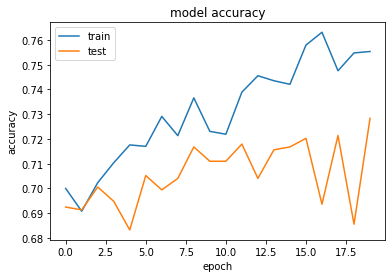

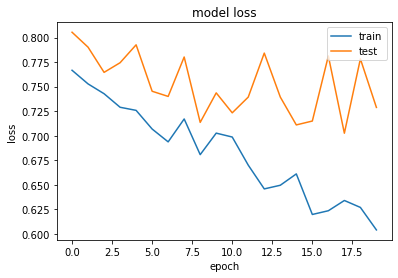

In [ ]:
plt.plot(hist_vgg19.history['accuracy'])
plt.plot(hist_vgg19.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

plt.figure()
plt.gcf().clear()
plt.plot(hist_vgg19.history['loss'])
plt.plot(hist_vgg19.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()


### ResNet50 Model

In [ ]:


def build_ResNet50(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape= input_shape)
    
    x_model = base_model.output
    
    x_model = AvgPool2D(name='globalaveragepooling2d')(x_model)
    
    x_model = Dense(1024, activation='relu',name='fc1_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_1')(x_model)
    x_model = Flatten()(x_model)
    x_model = Dense(256, activation='relu',name='fc2_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_2')(x_model)
    
    predictions = Dense(4, activation='sigmoid',name='output_layer')(x_model)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [ ]:
input_shape = (224,224,3)
model4_resnet50 = build_ResNet50(input_shape)
model4_resnet50.summary()


94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
# Compile the model ResNet50
model4_resnet50.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
nb_epoch = 20
batch_size = 32
stop_patience = 5
steps_per_epoch= 100
validation_steps= 100


In [ ]:
# Train the model ResNet50

from keras.callbacks import ModelCheckpoint, EarlyStopping
#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', verbose=1, monitor='val_acc',
                               #save_best_only=True, save_weights_only=True)
#early_stopper = EarlyStopping(monitor = 'val_loss', patience = stop_patience )
#model_fit_time_Resnet50_start = timeit.default_timer()

hist_resnet50 = model4_resnet50.fit(train_generator, validation_data=validation_generator,batch_size=batch_size, epochs=nb_epoch )

#model_fit_time_Resnet50_stop = timeit.default_timer()
#model_fit_time_Resnet50 = model_fit_time_Resnet50_stop - model_fit_time_Resnet50_start

Epoch 1/20
109/109 [==============================] - 958s 9s/step - loss: 2.0429 - accuracy: 0.3640 - val_loss: 1.4376 - val_accuracy: 0.2543
Epoch 2/20
109/109 [==============================] - 68s 626ms/step - loss: 1.2358 - accuracy: 0.5063 - val_loss: 1.7561 - val_accuracy: 0.2532
Epoch 3/20
109/109 [==============================] - 68s 622ms/step - loss: 0.9868 - accuracy: 0.6055 - val_loss: 1.6700 - val_accuracy: 0.2335
Epoch 4/20
109/109 [==============================] - 69s 634ms/step - loss: 0.8223 - accuracy: 0.6654 - val_loss: 1.5142 - val_accuracy: 0.2855
Epoch 5/20
109/109 [==============================] - 68s 624ms/step - loss: 0.7267 - accuracy: 0.7213 - val_loss: 1.3761 - val_accuracy: 0.3746
Epoch 6/20
109/109 [==============================] - 69s 627ms/step - loss: 0.6430 - accuracy: 0.7435 - val_loss: 0.9748 - val_accuracy: 0.5838
Epoch 7/20
109/109 [==============================] - 68s 622ms/step - loss: 0.5896 - accuracy: 0.7640 - val_loss: 0.6216 - val_accu

### Visualize the Resnet50 model accuracy and loss

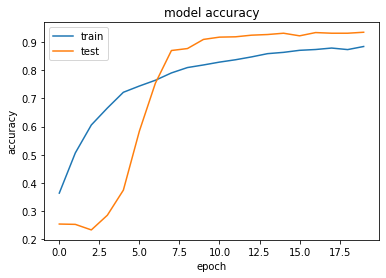

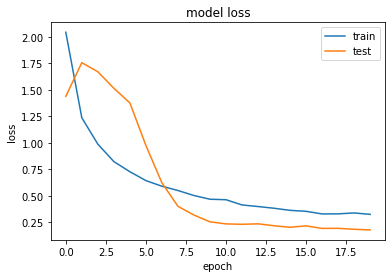

In [ ]:
plt.plot(hist_resnet50.history['accuracy'])
plt.plot(hist_resnet50.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

plt.figure()
plt.gcf().clear()
plt.plot(hist_resnet50.history['loss'])
plt.plot(hist_resnet50.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

## Transfer learning
Transfer learning is most useful when working with very small datasets. To keep our
dataset small, we will use 80% of the original data  for
 training, 20% for validation.

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.